In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# adfuller test
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)  # p<0.05, Stationary

In [3]:
ten_stocks_close = pd.read_csv('close_df.csv')

In [4]:
pool = ["600094.XSHG",    
        "600160.XSHG", 
        "600008.XSHG",
        "600903.XSHG",
        "000959.XSHE",
        "600970.XSHG",
        "002302.XSHE",
        "600823.XSHG",
        "002503.XSHE",
        "600664.XSHG"]

In [5]:
close_price = ten_stocks_close['600823.XSHG']

## Ljung Box Test on close price

In [6]:
import statsmodels.api as sm
sm.stats.acorr_ljungbox(close_price, lags=[12], return_df=True) # The p-value closes to 0. Has dependency

,lb_stat,lb_pvalue
12,13770.490295,0.0


## Stationarity on close price first

In [7]:
test_stationarity(close_price) # p-value is larger than 0.05. Has unit root

Results of Dickey-Fuller Test:
Test Statistic                   -2.734344
p-value                           0.068281
#Lags Used                       16.000000
Number of Observations Used    1409.000000
Critical Value (1%)              -3.435000
Critical Value (5%)              -2.863593
Critical Value (10%)             -2.567863
dtype: float64


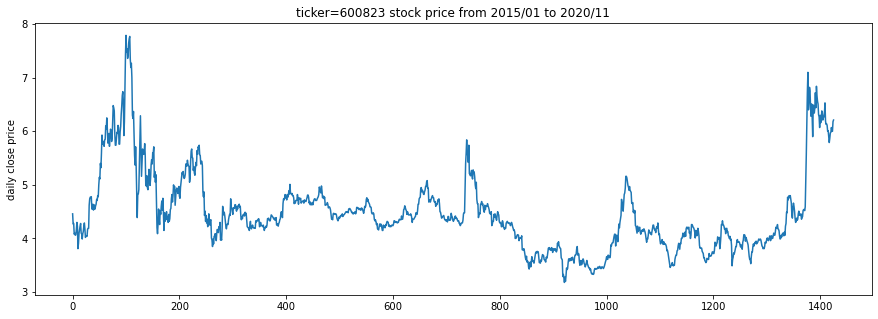

In [8]:
# visualize daily close data, lable y = column 1, ticker = 600823
close_price.plot(figsize=(15,5))
plt.ylabel('daily close price')
plt.title('ticker=600823 stock price from 2015/01 to 2020/11')
plt.show()

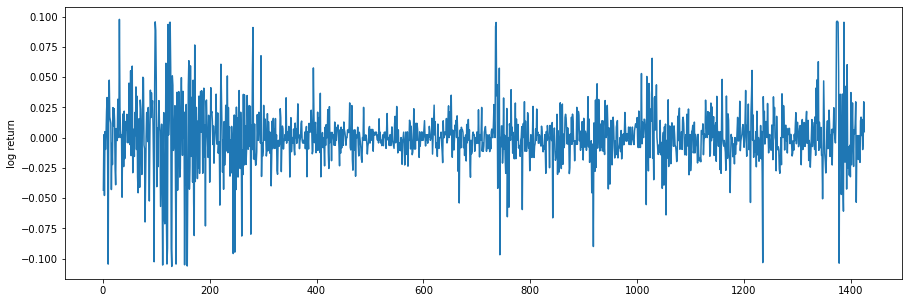

In [9]:
log_rtn = np.log(close_price).diff(1).dropna()
log_rtn.plot(figsize=(15,5))
plt.ylabel('log return')
plt.show()

## Test stationarity

In [10]:
test_stationarity(log_rtn) #p-value is small, it's stationary

Results of Dickey-Fuller Test:
Test Statistic                -9.696598e+00
p-value                        1.100134e-16
#Lags Used                     1.500000e+01
Number of Observations Used    1.409000e+03
Critical Value (1%)           -3.435000e+00
Critical Value (5%)           -2.863593e+00
Critical Value (10%)          -2.567863e+00
dtype: float64


## ACF & PACF

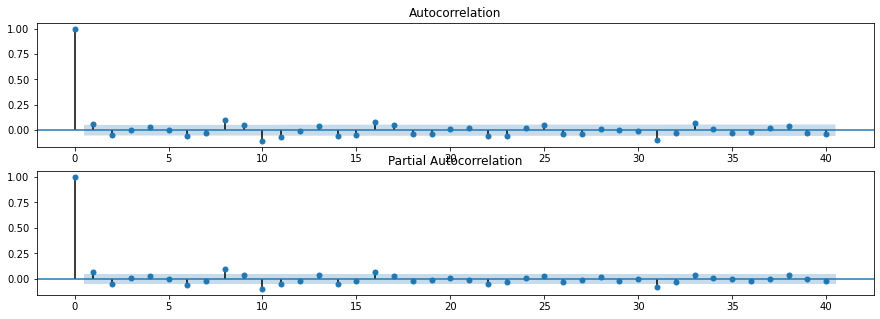

In [11]:
# acf & pacf for log return
import statsmodels.api as sm
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(log_rtn, lags=40, ax=ax1) 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(log_rtn, lags=40, ax=ax2)

## Distribution of log return

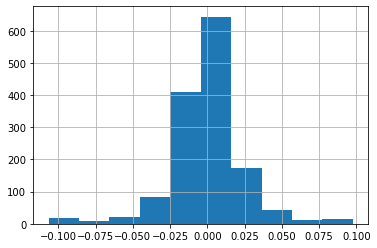

In [12]:
log_rtn.hist()
plt.show()

## Fit ARMA Model

In [13]:
import pandas as pd
import itertools
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.arima_model import ARIMA

p = range(5)
q = range(5)

combinations = list(itertools.product(p, q))
combinations = combinations[1:] # Drop (0,0)
def train_ARMA(param):
    try:
        p = param[0]
        q = param[1]
        model = ARIMA(log_rtn, order=(p,0,q))

        model_fit = model.fit(disp=0)

        ljung_p = sm.stats.acorr_ljungbox(model_fit.resid, lags=[12-p-q], return_df=True).values[0][1]
        aic = model_fit.aic
        return {'p': p, 'q': q, 'ljung_p': ljung_p, 'aic': aic}
    except:
        print(param)

results = pd.DataFrame(columns=['p', 'q', 'ljung_p', 'aic'])
for pq in combinations:
    results = results.append(train_ARMA(pq), ignore_index=True) 

results[results['ljung_p']>=0.05].sort_values(by=['aic'])

,p,q,ljung_p,aic
23,4.0,4.0,0.459198,-6595.376745
16,3.0,2.0,0.918354,-6593.166786
13,2.0,4.0,0.946365,-6591.225781
21,4.0,2.0,0.946943,-6591.168234
17,3.0,3.0,0.946665,-6591.167781
18,3.0,4.0,0.890850,-6589.025749
22,4.0,3.0,0.705243,-6587.934807
12,2.0,3.0,0.523711,-6554.484122
20,4.0,1.0,0.743424,-6550.970225
8,1.0,4.0,0.673500,-6550.390041


## GARCH

In [14]:
mean = log_rtn.mean() # The mean closes to 0

### Check if volatility time dependency

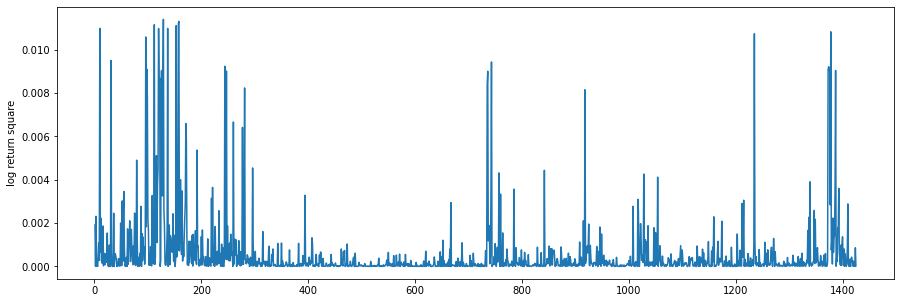

In [15]:
#log return square 
log_rtn_square = np.square(log_rtn - mean)
log_rtn_square.plot(figsize=(15,5))
plt.ylabel('log return square')
plt.show()

In [17]:
import statsmodels.api as sm

p_2 = sm.stats.acorr_ljungbox(log_rtn_square, lags=[40], return_df=True)['lb_pvalue'].values[0] # log return square is white noise if p < 0.05

print(f"P-value for squared log return: {p_2}")
if (p_2<0.05):
    print("Conclusion: Has ARCH's property in log rtn")
else:
    print("Conclusion: No ARCH's property in log rtn")

P-value for squared log return: 1.3500693175575163e-305
Conclusion: Has ARCH's property in log rtn


## EGARCH

In [18]:
from arch.univariate import arch_model
import itertools
import warnings
warnings.filterwarnings("ignore")

p = range(1,4)
q = range(1,4)

combinations = list(itertools.product(p, q))

def train_EGARCH(param):
    p = param[0]
    q = param[1]
    model = arch_model(log_rtn, vol='EGARCH', mean='constant', p=p, q=q, dist='t')
    
    res = model.fit(update_freq=0)
    
    ljung_p = sm.stats.acorr_ljungbox(res.std_resid, lags=[12], return_df=True).values[0][1]
    aic = res.aic
    return {'p':p, 'q': q, 'params': res.params, 'ljung_p': ljung_p, 'aic': aic}

results = pd.DataFrame(columns=['p', 'q', 'params', 'ljung_p', 'aic'])

for pq in combinations:
    try:
        results = results.append(train_EGARCH(pq), ignore_index=True)
    except:
        continue

results[results['ljung_p']>=0.05].sort_values(by=['aic'])

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3674.3245685808406
            Iterations: 14
            Function evaluations: 107
            Gradient evaluations: 14
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3674.325906690528
            Iterations: 20
            Function evaluations: 169
            Gradient evaluations: 20
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3674.325906512078
            Iterations: 31
            Function evaluations: 277
            Gradient evaluations: 31
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3674.3249806072345
            Iterations: 15
            Function evaluations: 133
            Gradient evaluations: 15
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3675.1495514193343
            Iterations: 25
            Funct

,p,q,params,ljung_p,aic
0,1,1,mu 0.000186 omega -0.100174 alph...,0.327545,-7338.649137
1,1,2,mu 0.000184 omega -0.102065 alph...,0.333480,-7336.651813
3,2,1,mu 0.000185 omega -0.099875 alph...,0.329558,-7336.649961
4,2,2,mu 0.000176 omega -0.199852 alph...,0.362042,-7336.299103
6,3,1,mu 0.000167 omega -0.108797 alph...,0.308261,-7335.295487
2,1,3,mu 0.000184 omega -0.102092 alph...,0.333533,-7334.651813
8,3,3,mu 1.059161e-04 omega -2.521467e...,0.353964,-7334.398566
5,2,3,mu 1.762451e-04 omega -1.998638e...,0.362013,-7334.299102
7,3,2,mu 0.000165 omega -0.133997 alph...,0.315507,-7333.493813
